In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pandas as pd
from scipy import ndimage
import pmesh
from mpi4py import MPI
from nbodykit.algorithms import FFTPower
import matplotlib.gridspec as gridspec
from scipy import signal
from scipy.special import eval_legendre
from nbodykit.binned_statistic import BinnedStatistic

%load_ext autoreload
%autoreload 2

/home/groups/tabel/mahlet/nbody-env/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Load the data for a particular mock (sample from the Latin Hypercube (LH)).

In [2]:
tag_params = '_p5_n10000'
idx_LH = 0

# change this directory path as needed
dir_mocks = f'/scratch/users/kstoreyf/muchisimocks/muchisimocks_lib{tag_params}'
subdir_prefix = 'LH'
fn_fields = f'{dir_mocks}/{subdir_prefix}{idx_LH}/bias_fields_eul_deconvolved_{idx_LH}.npy'
fn_fields_zspace = f'{dir_mocks}/{subdir_prefix}{idx_LH}/bias_fields_eul_zspace_deconvolved_{idx_LH}.npy'

bias_terms_eul = np.load(fn_fields)
bias_terms_eul_zspace = np.load(fn_fields_zspace)

Define plotting code

In [3]:
# copied from plotter.py (so that this notebook is self-contained)
def plot_field(tracer_field, normalize=False, vmin=None, vmax=None, 
                title=None, show_labels=True, show_colorbar=True,
                zslice_min=0, zslice_max=1, figsize=(6,6), log=False, symlog=False, 
                overdensity=True, label_cbar=None, plot = 'xy', interpolation = None):

        if normalize:
            tracer_field /= np.max(np.abs(tracer_field))
        
        if vmax is None:
            vmax = 3*np.std(tracer_field)
       
        if tracer_field.ndim==3:
            if plot == 'xy':
                field_2d = np.mean(tracer_field[:,:,zslice_min:zslice_max], axis=-1)
            elif plot == 'xz':
                field_2d = np.mean(tracer_field[:,zslice_min:zslice_max,:], axis=1)
            elif plot == 'yz':
                field_2d = np.mean(tracer_field[zslice_min:zslice_max,:,:], axis=0)
        elif tracer_field.ndim==2:
            field_2d = tracer_field
        else:
            raise ValueError("field must be 2d or 3d!")

        plt.figure(figsize=figsize, facecolor=(1,1,1,0))
        plt.title(title, fontsize=16)
        
        if symlog:
            from matplotlib.colors import SymLogNorm
            linthresh = 0.1*vmax
            linscale = 1.0
            if vmin is None:
                vmin = -vmax
            norm = SymLogNorm(
                    linthresh=linthresh, linscale=linscale,
                    vmin=vmin, vmax=vmax
                    )
        elif log:
            if vmin is None:
                vmin = np.min(tracer_field[tracer_field>0])
            norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
        else:
            if vmin is None:
                if overdensity:
                    vmin = -vmax
                else:
                    vmin = np.min(tracer_field[tracer_field>0])
            norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

        if overdensity:
            cmap = 'RdBu'
        else:
            cmap = 'Blues'
                
        im = plt.imshow(field_2d, norm=norm, cmap=cmap, interpolation = interpolation)
        ax = plt.gca()        
        
        if show_colorbar:
            if label_cbar is None:
                if overdensity:
                    label_cbar = r'overdensity $\delta$'
                else:
                    label_cbar = r'density'
            cbar = plt.colorbar(im, label=label_cbar, fraction=0.046, pad=0.04)
            cbar.ax.tick_params(labelsize=12) 
            
        if not show_labels:    
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)

        plt.show()

Define code to combine the fields

In [4]:
# copied from utils.py (so that this notebook is self-contained)
def get_tracer_field(bias_fields_eul, bias_vector, n_grid_norm=None):
    assert len(bias_vector)==bias_fields_eul.shape[0]-1, "bias_vector must have length one less than number of bias fields"
    if n_grid_norm is None:
        n_grid_norm = bias_fields_eul.shape[-1]
        
    def _sum_bias_fields(fields, bias_vector):
        bias_vector_extended = np.concatenate(([1.0], bias_vector))
        return np.sum([fields[ii]*bias_vector_extended[ii] for ii in range(len(fields))], axis=0)
    
    tracer_field_eul = _sum_bias_fields(bias_fields_eul, bias_vector)
    tracer_field_eul_norm = tracer_field_eul/n_grid_norm**3
    
    return tracer_field_eul_norm

In [5]:
def get_z_tracer_field(bias_params, bias_terms_eul = bias_terms_eul, n_grid_orig = 512, bias_terms_eul_zspace = bias_terms_eul_zspace):
    
    # Choose some bias vector and combine the bias fields into a tracer field
    # the order is b1, b2, bs2, blaplacian
    # use 512 for normalization, because this is the original resolution of the mocks (they were downsampled to 128)
    # this doesn't matter for visualization, but will when you go to compute statistics
    tracer_field_eul_norm = get_tracer_field(bias_terms_eul, bias_params, n_grid_norm=n_grid_orig)
    
    # Now plot in redshift-space! 
    tracer_field_eul_norm_zspace = get_tracer_field(bias_terms_eul_zspace, bias_params, n_grid_norm=n_grid_orig)

    plot_field(tracer_field_eul_norm_zspace, figsize=(6,6), title=rf'$z$-space tracer field, b={bias_params}', plot = 'xz',
                   show_labels=False, vmin=-5.25e-6, vmax=5.25e-6)
    
    return tracer_field_eul_norm_zspace, tracer_field_eul_norm

# Construct the fields in z space

## $\delta_{\mathrm{g}}(\vec{s}) \equiv\left(1-f_s\right) \delta_{\mathrm{g}}\left(\vec{s}_c\right)+f_s \delta_{\mathrm{g}}\left(\vec{s}_c\right) *_z \exp \left(-\lambda_{\mathrm{FoG}} \mathrm{~s}_{\mathrm{z}}\right)$

## Decide kernel length and RSD parameters

In [6]:
Lbox = 1000 # h/Mpc
Nbox = 128
N = 30

In [7]:
def Lkernel_func(N = N, Lbox = Lbox, Nbox = Nbox):
    
    return Lbox/Nbox*N # Mpc/h

def s_z_func(N = N, Lbox = Lbox, Nbox = Nbox):

    Lkernel = Lkernel_func(N)
    s_z = np.linspace(-Lkernel/2, Lkernel/2, N+1) # Mpc/h

    if np.diff(s_z)[0] != Lbox/Nbox:
        raise TypeError("make sure the kernel spacing matches the grid spacing")

    return s_z

def kernel_func(s_z, lambda_FOG):

    # normalize the kernel
    kernel = np.exp(-lambda_FOG*np.abs(s_z))
    norm = np.sum(kernel)

    return kernel/norm

## Compare to theory
### $P_{\mathrm{tr}}^{\mathrm{FoG}}(k, \mu)=P_{\mathrm{tr}}(k, \mu)\left(\left(1-f_{\mathrm{sat}}\right)+f_{\mathrm{sat}} \frac{\lambda_{\mathrm{FoG}}^2}{\lambda_{\mathrm{FoG}}^2+k^2 \mu^2}\right)^2$

In [8]:
def damp(kvals_z, lambda_FOG):
    
    return lambda_FOG**2/(lambda_FOG**2+kvals_z**2)

In [9]:
def RSD_theory(lin_pk, f_sat = 0.7, lambda_FOG = 0.3):
    
    return np.nanmean(lin_pk.power['power']*(1-f_sat+f_sat*damp(lin_pk.power['k']*lin_pk.power['mu'], lambda_FOG))**2, axis = 1)

In [10]:
def lin_pk_func(tracer_field_eul_norm_zspace, l = 0, Nbox = Nbox, comm = MPI.COMM_WORLD, Nmu = 5, norm = 128**6):

    pm = pmesh.pm.ParticleMesh([Nbox, Nbox, Nbox], Lbox, dtype='float32', resampler='cic', comm=comm)

    # initialize a RealField
    gal_field = pmesh.pm.RealField(pm)
    gal_field[...] = tracer_field_eul_norm_zspace
    # gal_field = gal_field.apply(CompensateCIC) # this doesn't help
 
    # Create the FFTPower objects
    lin_pk = FFTPower(gal_field.r2c(), '2d', kmin = 1e-5, kmax = 0.64, poles = [l], Nmu = Nmu)

    # k arrays are set like this
    kvals = lin_pk.poles['k'] # let's ignore the artificial zero k value

    # correct normalization
    lin_pk.power['power'] *= norm
    
    return lin_pk.poles['power_'+str(l)].real*norm, kvals, lin_pk

def delta_FOG_func(tracer_field_eul_norm_zspace, f_sat = 0.7, lambda_FOG = 0.3, N = N):
    
    # Start with large-scale RSDs
    RSD_large = tracer_field_eul_norm_zspace*(1-f_sat)

    # Now compute small-scale RSDs
    RSD_small = f_sat*ndimage.convolve1d(tracer_field_eul_norm_zspace, kernel_func(s_z_func(N), lambda_FOG), mode = 'wrap')

    # Add them together to get full RSDs
    return RSD_large+RSD_small

## Pick a set of bias and RSD parameters

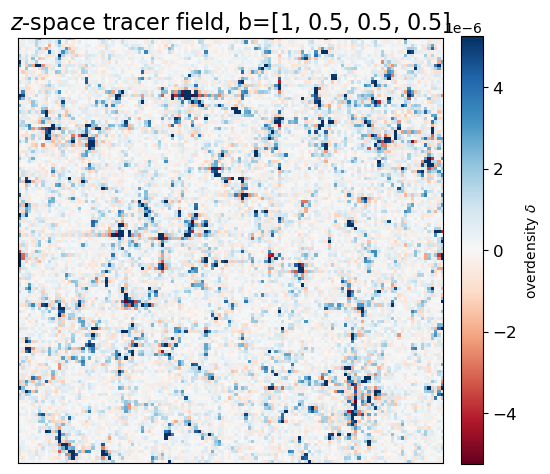

In [11]:
bias_params = [1, 0.5, 0.5, 0.5]
tracer_field_eul_norm_zspace, tracer_field_eul_norm = get_z_tracer_field(bias_params)

# RSD parameters
lambda_FOG = 0.3 # Mpc/h
f_sat = 0.7 

/home/groups/tabel/mahlet/nbody-env/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


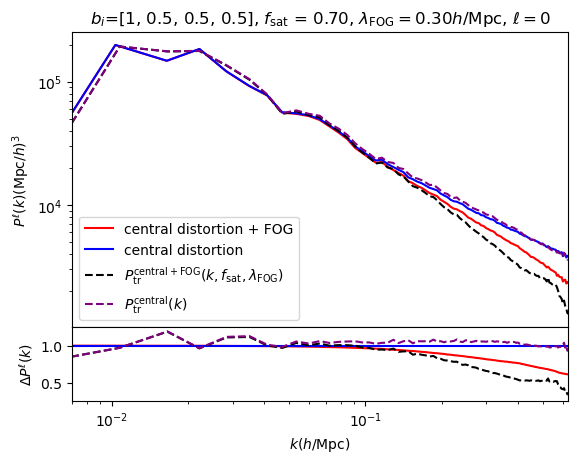

In [12]:
Nmu = 1000

fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios = [4,1])
gs.update(hspace = 0, wspace = 0)
xlim = 7e-3, 0.63
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

# try computing P(k) of central distortion effect only
lin_pk_fid_power, kvals, lin_pk_fid = lin_pk_func(tracer_field_eul_norm_zspace, Nmu = Nmu)

# Add them together to get full RSDs
lin_pk_RSD_power, kvals_RSD, lin_pk_RSD = lin_pk_func(delta_FOG_func(tracer_field_eul_norm_zspace, lambda_FOG = lambda_FOG), Nmu = Nmu)
ax0.loglog(kvals_RSD, lin_pk_RSD_power, color = 'red',
                                  label = 'central distortion + FOG')
ax1.plot(kvals_RSD, lin_pk_RSD_power/lin_pk_fid_power, color = 'red')

# plot central distortion effect only
ax0.loglog(kvals, lin_pk_fid_power, color = 'blue', label = 'central distortion') 
ax1.axhline(1, color = 'blue')

# try computing P(k) using the theory model + averaging method
theory = RSD_theory(lin_pk_fid, f_sat = f_sat, lambda_FOG = lambda_FOG)
P_k = lin_pk_fid.power.average('mu')
ax0.loglog(P_k['k'], theory, label = '$P_\mathrm{{tr}}^\mathrm{{central + FOG}}(k, f_\mathrm{{sat}}, \lambda_\mathrm{{FOG}})$', 
           color = 'black', linestyle = '--')
ax1.plot(P_k['k'], theory/lin_pk_fid_power, color = 'black', linestyle = '--') #the kvals don't technically match up here...

# try computing P(k) from P(k, mu) of the central distortion effect to check averaging method
ax0.loglog(P_k['k'], P_k['power'], label = '$P_\mathrm{{tr}}^\mathrm{{central}}(k)$', color = 'purple', linestyle = '--')
ax1.plot(P_k['k'], P_k['power']/lin_pk_fid_power, color = 'purple', linestyle = '--') #the kvals don't technically match up here...

ax0.legend()
ax0.set_ylabel(r'$P^{\ell}(k) $(Mpc$/h)^3$')
ax0.set_xlim(xlim)
ax0.set_xticks([])
ax0.set_title('$b_i$={:s}, $f_\mathrm{{sat}}$ = {:.2f}, $\lambda_\mathrm{{FOG}}={:.2f} h/$Mpc, $\ell=${:d}'.format(str(bias_params), f_sat, 
                                                                                                                   lambda_FOG, 0))
ax1.set_xlabel('$k (h/$Mpc)')
ax1.set_ylabel(r'$\Delta P^{\ell}(k)$')
ax1.set_xlim(xlim)
ax1.set_ylim(0.25, 1.25)
ax1.set_xscale('log')

plt.show()

In [13]:
# Plot clustering
def plot_kPk(ax0, ax1, tracer_field_eul_norm_zspace, tracer_field_eul_norm, label, color, l = 0, comm = MPI.COMM_WORLD,
             linestyle = '-', legend = True, Nmu = 5, version = 0, alpha = 1): 

    lin_pk_pole_z, kvals_z, lin_pk_z = lin_pk_func(tracer_field_eul_norm_zspace, Nmu = Nmu)
    lin_pk_pole_real, kvals_real, lin_pk_real = lin_pk_func(tracer_field_eul_norm, Nmu = Nmu)

    if (kvals_z!=kvals_real).any():
        raise TypeError("make sure the kvals are the same")
        
    # Plot the P(k)
    ax0.plot(kvals_z, kvals_z*lin_pk_pole_z, linestyle = linestyle, label = label, alpha = alpha, color = color) 

    # Plot the ratio
    ax1.plot(kvals_z, lin_pk_pole_z/lin_pk_pole_real, linestyle = linestyle, label = label, alpha = alpha, color = color) 
    
    return lin_pk_z, kvals_real, lin_pk_pole_real

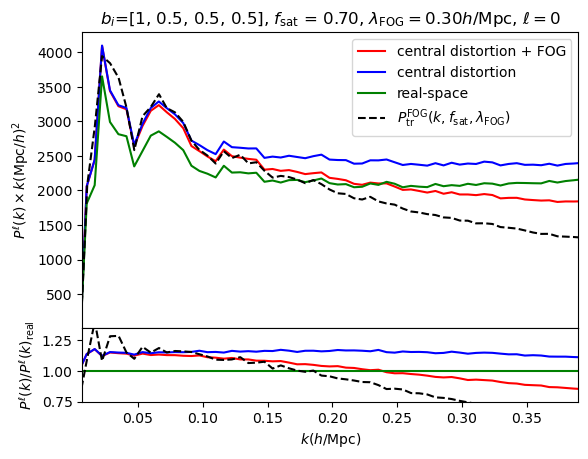

In [14]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios = [4,1])
gs.update(hspace = 0, wspace = 0)

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
xlim = (7e-3, 0.39)

# f_sat = 0.7
# lambda_FOG = 0.3
Nmu = 1000

# Add them together to get full RSDs
delta_FOG = delta_FOG_func(tracer_field_eul_norm_zspace, f_sat = f_sat, lambda_FOG = lambda_FOG)

plot_kPk(ax0, ax1, delta_FOG, tracer_field_eul_norm, label = 'central distortion + FOG', color = 'red')
lin_pk_z, kvals_real, lin_pk_pole_real = plot_kPk(ax0, ax1, tracer_field_eul_norm_zspace, tracer_field_eul_norm, label = 'central distortion', color = 'blue', 
                                                  Nmu = Nmu)
plot_kPk(ax0, ax1, tracer_field_eul_norm, tracer_field_eul_norm, label = 'real-space', color = 'green')

P_k = lin_pk_z.power.average('mu')
theory = RSD_theory(lin_pk_z, f_sat = f_sat, lambda_FOG = lambda_FOG)
ax0.plot(P_k['k'], P_k['k']*theory, label = '$P_\mathrm{{tr}}^\mathrm{{FOG}}(k, f_\mathrm{{sat}}, \lambda_\mathrm{{FOG}})$', color = 'black', 
         linestyle = '--')
ax1.plot(P_k['k'], theory/lin_pk_pole_real, color = 'black', linestyle = '--') #the kvals don't technically match up here...
        
ax0.legend()
ax0.set_xlim(xlim)
ax0.set_xticklabels([])
ax0.set_title('$b_i$={:s}, $f_\mathrm{{sat}}$ = {:.2f}, $\lambda_\mathrm{{FOG}}={:.2f} h/$Mpc, $\ell=${:d}'.format(str(bias_params), f_sat, 
                                                                                                                   lambda_FOG, 0))
# ax0.set_ylim(0e-10, 9.75e-10)
ax0.set_ylabel(r'$P^{\ell}(k)\times k $(Mpc$/h)^2$')

ax1.set_xlim(xlim)
ax1.set_ylim(0.75, 1.35)
ax1.set_xlabel('$k (h/$Mpc)')
ax1.set_ylabel('$P^{\ell}(k)/P^{\ell}(k)_\mathrm{real}$')

plt.show()

## Try a more realistic set of bias and RSD parameters 

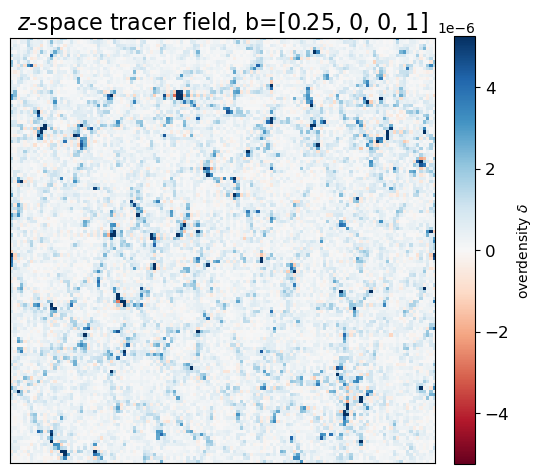

In [15]:
# Match to values used in Fig 5 for high density SM-selected sample at z=0
bias_params = [0.25, 0, 0, 1]
tracer_field_eul_norm_zspace, tracer_field_eul_norm = get_z_tracer_field(bias_params)

# RSD parameters
f_sat = 0.4
lambda_FOG = 0.2 # h/Mpc

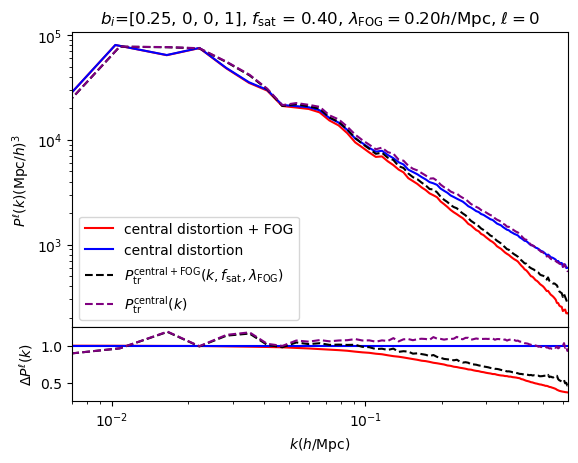

In [16]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios = [4,1])
gs.update(hspace = 0, wspace = 0)
xlim = 7e-3, 0.63
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

# try computing P(k) of central distortion effect only
lin_pk_fid_power, kvals, lin_pk_fid = lin_pk_func(tracer_field_eul_norm_zspace, Nmu = Nmu)

# Add them together to get full RSDs
lin_pk_RSD_power, kvals_RSD, lin_pk_RSD = lin_pk_func(delta_FOG_func(tracer_field_eul_norm_zspace, lambda_FOG = lambda_FOG), Nmu = Nmu)
ax0.loglog(kvals_RSD, lin_pk_RSD_power, color = 'red',
                                  label = 'central distortion + FOG')
ax1.plot(kvals_RSD, lin_pk_RSD_power/lin_pk_fid_power, color = 'red')

# plot central distortion effect only
ax0.loglog(kvals, lin_pk_fid_power, color = 'blue', label = 'central distortion') 
ax1.axhline(1, color = 'blue')

# try computing P(k) using the theory model + averaging method
theory = RSD_theory(lin_pk_fid, f_sat = f_sat, lambda_FOG = lambda_FOG)
ax0.loglog(P_k['k'], theory, label = '$P_\mathrm{{tr}}^\mathrm{{central + FOG}}(k, f_\mathrm{{sat}}, \lambda_\mathrm{{FOG}})$', 
           color = 'black', linestyle = '--')
ax1.plot(P_k['k'], theory/lin_pk_fid_power, color = 'black', linestyle = '--') #the kvals don't technically match up here...

# try computing P(k) from P(k, mu) of the central distortion effect to check averaging method
P_k = lin_pk_fid.power.average('mu')
ax0.loglog(P_k['k'], P_k['power'], label = '$P_\mathrm{{tr}}^\mathrm{{central}}(k)$', color = 'purple', linestyle = '--')
ax1.plot(P_k['k'], P_k['power']/lin_pk_fid_power, color = 'purple', linestyle = '--') #the kvals don't technically match up here...

ax0.legend()
ax0.set_ylabel(r'$P^{\ell}(k) $(Mpc$/h)^3$')
ax0.set_xlim(xlim)
ax0.set_xticks([])
ax0.set_title('$b_i$={:s}, $f_\mathrm{{sat}}$ = {:.2f}, $\lambda_\mathrm{{FOG}}={:.2f} h/$Mpc, $\ell=${:d}'.format(str(bias_params), f_sat, 
                                                                                                                   lambda_FOG, 0))
ax1.set_xlabel('$k (h/$Mpc)')
ax1.set_ylabel(r'$\Delta P^{\ell}(k)$')
ax1.set_xlim(xlim)
ax1.set_ylim(0.25, 1.25)
ax1.set_xscale('log')
plt.show()

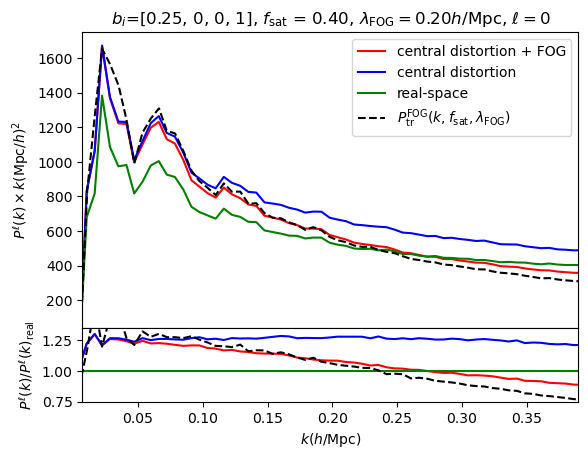

In [17]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios = [4,1])
gs.update(hspace = 0, wspace = 0)

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
xlim = (7e-3, 0.39) #5e-3

# Add them together to get full RSDs
delta_FOG = delta_FOG_func(tracer_field_eul_norm_zspace, f_sat = f_sat, lambda_FOG = lambda_FOG)

plot_kPk(ax0, ax1, delta_FOG, tracer_field_eul_norm, label = 'central distortion + FOG', color = 'red')
lin_pk_z, kvals_real, lin_pk_pole_real = plot_kPk(ax0, ax1, tracer_field_eul_norm_zspace, tracer_field_eul_norm, label = 'central distortion', color = 'blue', 
                                                  Nmu = Nmu)
plot_kPk(ax0, ax1, tracer_field_eul_norm, tracer_field_eul_norm, label = 'real-space', color = 'green')

P_k = lin_pk_z.power.average('mu')
theory = RSD_theory(lin_pk_z, f_sat = f_sat, lambda_FOG = lambda_FOG)
ax0.plot(P_k['k'], P_k['k']*theory, label = '$P_\mathrm{{tr}}^\mathrm{{FOG}}(k, f_\mathrm{{sat}}, \lambda_\mathrm{{FOG}})$', color = 'black', 
         linestyle = '--')
ax1.plot(P_k['k'], theory/lin_pk_pole_real, color = 'black', linestyle = '--') #the kvals don't technically match up here...
        
ax0.legend()
ax0.set_xlim(xlim)
ax0.set_xticklabels([])
ax0.set_title('$b_i$={:s}, $f_\mathrm{{sat}}$ = {:.2f}, $\lambda_\mathrm{{FOG}}={:.2f} h/$Mpc, $\ell=${:d}'.format(str(bias_params), f_sat, 
                                                                                                                   lambda_FOG, 0))
# ax0.set_ylim(0e-10, 9.75e-10)
ax0.set_ylabel(r'$P^{\ell}(k)\times k $(Mpc$/h)^2$')

ax1.set_xlim(xlim)
ax1.set_ylim(0.75, 1.35)
ax1.set_xlabel('$k (h/$Mpc)')
ax1.set_ylabel('$P^{\ell}(k)/P^{\ell}(k)_\mathrm{real}$')

plt.show()

## Try it in 2D
### Monopole first

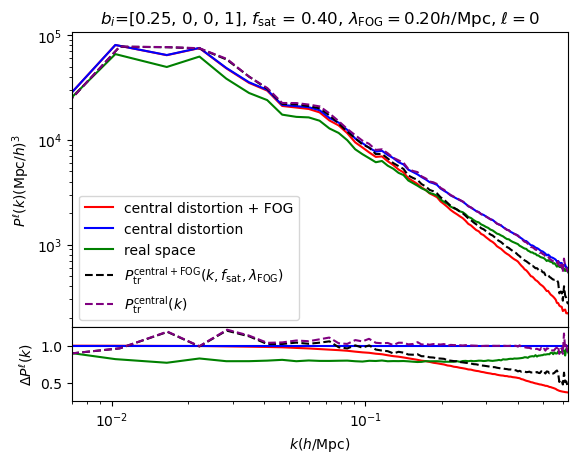

In [18]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios = [4,1])
gs.update(hspace = 0, wspace = 0)
xlim = 7e-3, 0.63
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
Nmu = 101

# try computing P(k) of central distortion effect only
lin_pk_fid_power, kvals, lin_pk_fid = lin_pk_func(tracer_field_eul_norm_zspace, Nmu = Nmu)

# Add them together to get full RSDs
lin_pk_RSD_power, kvals_RSD, lin_pk_RSD = lin_pk_func(delta_FOG_func(tracer_field_eul_norm_zspace, lambda_FOG = lambda_FOG), Nmu = Nmu)
ax0.loglog(kvals_RSD, lin_pk_RSD_power, color = 'red',
                                  label = 'central distortion + FOG')
ax1.plot(kvals_RSD, lin_pk_RSD_power/lin_pk_fid_power, color = 'red')

# plot central distortion effect only
ax0.loglog(kvals, lin_pk_fid_power, color = 'blue', label = 'central distortion') 
ax1.axhline(1, color = 'blue')

# plot real space
lin_pk_pole_real, kvals_real, lin_pk_real = lin_pk_func(tracer_field_eul_norm, Nmu = Nmu)
ax0.loglog(kvals_real, lin_pk_pole_real, color = 'green', label = 'real space') 
ax1.plot(kvals_real, lin_pk_pole_real/lin_pk_fid_power, color = 'green')

# try computing P(k) using the theory model + averaging method
theory = RSD_theory(lin_pk_fid, f_sat = f_sat, lambda_FOG = lambda_FOG)
ax0.loglog(P_k['k'], theory, label = '$P_\mathrm{{tr}}^\mathrm{{central + FOG}}(k, f_\mathrm{{sat}}, \lambda_\mathrm{{FOG}})$', 
           color = 'black', linestyle = '--')
ax1.plot(P_k['k'], theory/lin_pk_fid_power, color = 'black', linestyle = '--') #the kvals don't technically match up here...

# try computing P(k) from P(k, mu) of the central distortion effect to check averaging method
P_k = lin_pk_fid.power.average('mu')
ax0.loglog(P_k['k'], P_k['power'], label = '$P_\mathrm{{tr}}^\mathrm{{central}}(k)$', color = 'purple', linestyle = '--')
ax1.plot(P_k['k'], P_k['power']/lin_pk_fid_power, color = 'purple', linestyle = '--') #the kvals don't technically match up here...

ax0.legend()
ax0.set_ylabel(r'$P^{\ell}(k) $(Mpc$/h)^3$')
ax0.set_xlim(xlim)
ax0.set_xticks([])
ax0.set_title('$b_i$={:s}, $f_\mathrm{{sat}}$ = {:.2f}, $\lambda_\mathrm{{FOG}}={:.2f} h/$Mpc, $\ell=${:d}'.format(str(bias_params), f_sat, 
                                                                                                                   lambda_FOG, 0))
ax1.set_xlabel('$k (h/$Mpc)')
ax1.set_ylabel(r'$\Delta P^{\ell}(k)$')
ax1.set_xlim(xlim)
ax1.set_ylim(0.25, 1.25)
ax1.set_xscale('log')
plt.show()

In [19]:
def RSD_theory_2D(lin_pk, f_sat = 0.7, lambda_FOG = 0.3):

    return lin_pk.power['power']*(1-f_sat+f_sat*damp(lin_pk.power['k']*lin_pk.power['mu'], lambda_FOG))**2

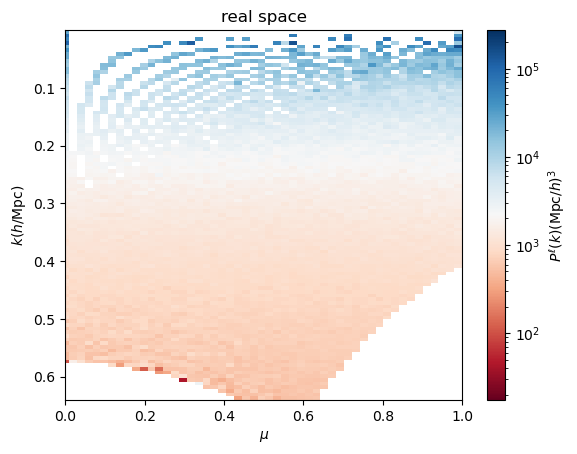

In [20]:
vmin, vmax = 1.75e1, 2.75e5
im = plt.imshow(np.real(lin_pk_real.power['power']), cmap = 'RdBu', norm = 'log', extent=[-1,1,0.64,1e-5], aspect = 'auto', vmin = vmin, vmax = vmax)
plt.title('real space')
plt.colorbar(im, label = r'$P^{\ell}(k) $(Mpc$/h)^3$')
plt.xlabel('$\mu$')
plt.ylabel('$k(h/$Mpc)')
plt.xlim(0, 1)
plt.show()

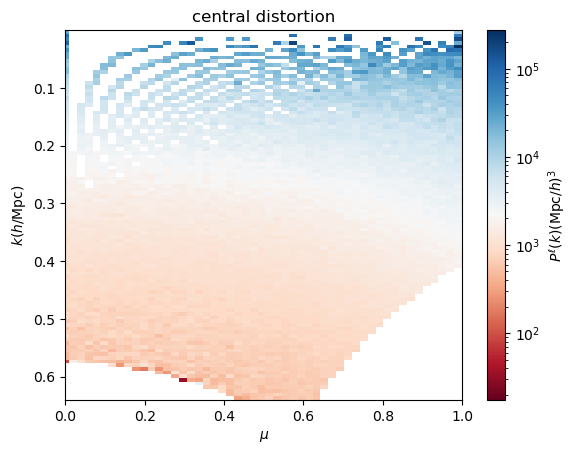

In [21]:
im = plt.imshow(np.real(lin_pk_fid.power['power']), cmap = 'RdBu', norm = 'log',  extent=[-1,1,0.64,1e-5], aspect = 'auto', vmin = vmin, vmax = vmax)
plt.title('central distortion')
plt.colorbar(im, label = r'$P^{\ell}(k) $(Mpc$/h)^3$')
plt.xlabel('$\mu$')
plt.ylabel('$k(h/$Mpc)')
plt.xlim(0, 1)
plt.show()

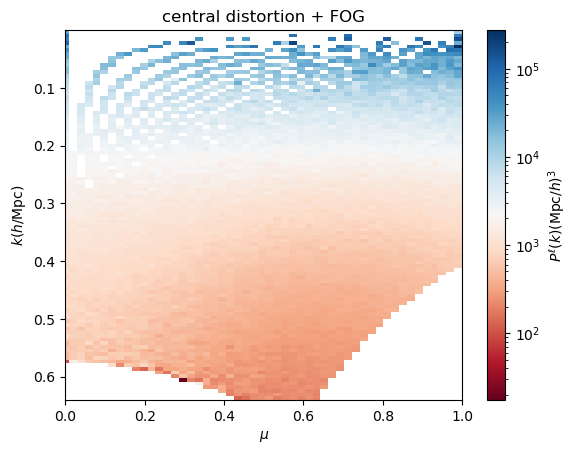

In [22]:
im = plt.imshow(np.real(lin_pk_RSD.power['power']), cmap = 'RdBu', norm = 'log', extent=[-1,1,0.64,1e-5], aspect = 'auto', vmin = vmin, vmax = vmax)
plt.title('central distortion + FOG')
plt.colorbar(im, label = r'$P^{\ell}(k) $(Mpc$/h)^3$')
plt.xlabel('$\mu$')
plt.ylabel('$k(h/$Mpc)')
plt.xlim(0, 1)
plt.show()

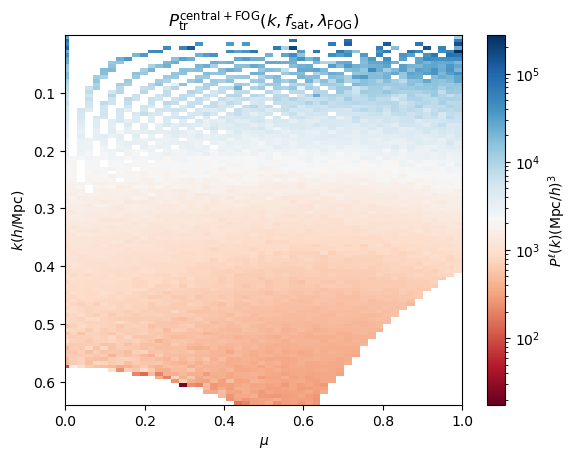

In [23]:
theory = RSD_theory_2D(lin_pk_fid, f_sat = f_sat, lambda_FOG = lambda_FOG)
im = plt.imshow(np.real(theory), cmap = 'RdBu', norm = 'log', extent=[-1,1,0.64,1e-5], aspect = 'auto', vmin = vmin, vmax = vmax)
plt.title('$P_\mathrm{{tr}}^\mathrm{{central + FOG}}(k, f_\mathrm{{sat}}, \lambda_\mathrm{{FOG}})$')
plt.colorbar(im, label = r'$P^{\ell}(k) $(Mpc$/h)^3$')
plt.xlabel('$\mu$')
plt.ylabel('$k(h/$Mpc)')
plt.xlim(0, 1)
plt.show()

## Try fixing normalization

In [26]:
def lin_pk_func_old(tracer_field_eul_norm_zspace, l = 0, Nbox = Nbox, comm = MPI.COMM_WORLD, Nmu = 5):

    pm = pmesh.pm.ParticleMesh([Nbox, Nbox, Nbox], Lbox, dtype='float32', resampler='cic', comm=comm)

    # initialize a RealField
    gal_field = pmesh.pm.RealField(pm)
    gal_field[...] = tracer_field_eul_norm_zspace
    # gal_field = gal_field.apply(CompensateCIC) # this doesn't help
 
    # Create the FFTPower objects
    lin_pk = FFTPower(gal_field.r2c(), '2d', kmin = 1e-5, kmax = 0.64, poles = [l], Nmu = Nmu)

    # k arrays are set like this
    kvals = lin_pk.poles['k'] # let's ignore the artificial zero k value
    
    return lin_pk.poles['power_'+str(l)].real, kvals, lin_pk

In [27]:
# Plot clustering
def plot_kPk_norm(ax0, ax1, tracer_field_eul_norm_zspace, tracer_field_eul_norm, label, color, l = 0, comm = MPI.COMM_WORLD,
             linestyle = '-', legend = True, Nmu = 5, version = 0, alpha = 1, norm = 128**6): 

    lin_pk_pole_z, kvals_z, lin_pk_z = lin_pk_func_old(tracer_field_eul_norm_zspace, Nmu = Nmu)
    lin_pk_pole_real, kvals_real, lin_pk_real = lin_pk_func_old(tracer_field_eul_norm, Nmu = Nmu)

    if (kvals_z!=kvals_real).any():
        raise TypeError("make sure the kvals are the same")
        
    # Plot the P(k)
    ax0.plot(kvals_z, kvals_z*lin_pk_pole_z*norm, linestyle = linestyle, label = label, alpha = alpha, color = color) 

    # Plot the ratio
    ax1.plot(kvals_z, lin_pk_pole_z/lin_pk_pole_real, linestyle = linestyle, label = label, alpha = alpha, color = color) 
    
    return lin_pk_z, kvals_real, lin_pk_pole_real

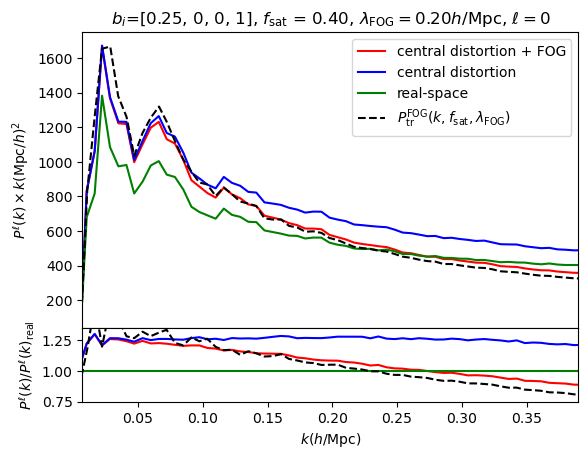

In [28]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios = [4,1])
gs.update(hspace = 0, wspace = 0)

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
xlim = (7e-3, 0.39) #5e-3
norm = 128**6

# Add them together to get full RSDs
delta_FOG = delta_FOG_func(tracer_field_eul_norm_zspace, f_sat = f_sat, lambda_FOG = lambda_FOG)

plot_kPk_norm(ax0, ax1, delta_FOG, tracer_field_eul_norm, label = 'central distortion + FOG', color = 'red')
lin_pk_z, kvals_real, lin_pk_pole_real = plot_kPk_norm(ax0, ax1, tracer_field_eul_norm_zspace, tracer_field_eul_norm, label = 'central distortion', color = 'blue', 
                                                  Nmu = Nmu)
plot_kPk_norm(ax0, ax1, tracer_field_eul_norm, tracer_field_eul_norm, label = 'real-space', color = 'green')

P_k = lin_pk_z.power.average('mu')
theory = RSD_theory(lin_pk_z, f_sat = f_sat, lambda_FOG = lambda_FOG)
ax0.plot(P_k['k'], P_k['k']*theory*norm, label = '$P_\mathrm{{tr}}^\mathrm{{FOG}}(k, f_\mathrm{{sat}}, \lambda_\mathrm{{FOG}})$', color = 'black', 
         linestyle = '--')
ax1.plot(P_k['k'], theory/lin_pk_pole_real, color = 'black', linestyle = '--') #the kvals don't technically match up here...
        
ax0.legend()
ax0.set_xlim(xlim)
ax0.set_xticklabels([])
ax0.set_title('$b_i$={:s}, $f_\mathrm{{sat}}$ = {:.2f}, $\lambda_\mathrm{{FOG}}={:.2f} h/$Mpc, $\ell=${:d}'.format(str(bias_params), f_sat, 
                                                                                                                   lambda_FOG, 0))
# ax0.set_ylim(0e-10, 9.75e-10)
ax0.set_ylabel(r'$P^{\ell}(k)\times k $(Mpc$/h)^2$')

ax1.set_xlim(xlim)
ax1.set_ylim(0.75, 1.35)
ax1.set_xlabel('$k (h/$Mpc)')
ax1.set_ylabel('$P^{\ell}(k)/P^{\ell}(k)_\mathrm{real}$')

plt.show()